# Pump it Up: Data Mining the Water Table 

Trabajo realizado por Laura Piñeros /UCM/Big Data

In [13]:
import pandas as pd
import numpy as np

from datetime import datetime
import requests
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

import re


from sklearn.preprocessing import LabelEncoder

# IQR/Z score.
from scipy.stats import stats

# Seleción de variables.
from sklearn.feature_selection import SelectKBest

# Modelos Selección.
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Modelos.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeClassifierCV
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.model_selection import (GridSearchCV, cross_val_score, RepeatedStratifiedKFold, 
StratifiedKFold, RandomizedSearchCV)
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.model_selection import StratifiedKFold


# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Preprocesado.
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE

# Métricas.
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, classification_report

from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

In [60]:

#funciones 
def show_missing_unique(df, data=None):
    dfx = pd.DataFrame({'type':df.dtypes,
                        'count': [df[col].count() for col in df.columns],
                        'missing':df.isnull().sum(),
                        '% missing':round(df.isnull().sum()*100/len(df),2),
                        'unique':[len(df[col].unique()) for col in df.columns],
                        '% unique':[round(len(df[col].unique())*100/len(df),2) for col in df.columns]})

    if data:
        dfx['type'] == 'float64' 
    return dfx.style.background_gradient(cmap='Blues')

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

def features_importance(X_train, y_train):
    cat = CatBoostClassifier(random_state=42, silent=True).fit(X_train, y_train).feature_importances_
    xgb = XGBClassifier(random_state=42, n_jobs=-1, verbosity=0).fit(X_train, y_train).feature_importances_
    rf = RandomForestClassifier(random_state=42, n_jobs=-1).fit(X_train, y_train).feature_importances_
    importances = sorted([(np.mean([x,y,z]),c) for x,y,z,c in zip(xgb, rf, cat, X_train.columns)])
    plt.figure(figsize=(10,len(X_train.columns)/2))
    plt.title("Feature importances")
    plt.bar(list(zip(*importances))[1], list(zip(*importances))[0],color='r',align="center")
    plt.xticks(rotation=45)
    return sorted(importances, reverse=True)

def metrics(tmp, predictions):
    print('matriz de confusión')
    print(confusion_matrix(tmp, predictions))
    print('accuracy')
    print(accuracy_score(tmp, predictions))

## Cargar los datasets y construir una tabla analítica con todas las variables

In [20]:
train_tmp = pd.read_csv('../multiclase/training_set_values.csv')
labels_tmp = LabelEncoder().fit_transform(pd.read_csv('../multiclase/training_set_labels.csv')['status_group'])
test_tmp = pd.read_csv("../multiclase/test_set_values.csv")

In [16]:
df = pd.concat([train_tmp, test_tmp],sort=False,ignore_index=True)
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [17]:
print('Tamaño de tabla Entrenamiento:',df.shape[0])

Tamaño de tabla Entrenamiento: 74250


## Que comprobar?
1.  Tipos de variables
2. Valores mal codificados 
3. Valores fuera de rango
-  Outliers(incidencia y conversión a missings)
-  Missings(incidencia e imputación)
 

# Pre procesado y limpieza de datos

In [22]:
show_missing_unique(df.replace(0,np.nan))

,type,count,missing,% missing,unique,% unique
id,float64,74249,1,0.000000,74250,100.000000
amount_tsh,float64,22201,52049,70.100000,102,0.140000
date_recorded,object,74250,0,0.000000,369,0.500000
funder,object,69746,4504,6.070000,2141,2.880000
gps_height,float64,48601,25649,34.540000,2456,3.310000
installer,object,69718,4532,6.100000,2411,3.250000
longitude,float64,71981,2269,3.060000,71870,96.790000
latitude,float64,74250,0,0.000000,71869,96.790000
wpt_name,object,74250,0,0.000000,45684,61.530000
num_private,float64,951,73299,98.720000,68,0.090000


In [23]:
cat_cols= df.select_dtypes(include=['object','category']).columns
num_cols = df.select_dtypes(exclude=['object','category']).columns      

In [24]:
df[cat_cols].describe()

,date_recorded,funder,installer,wpt_name,basin,subvillage,region,lga,ward,public_meeting,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
count,74250,69746,69718,74250,74250,73780,74250,74250,74250,70095,...,74250,74250,74250,74250,74250,74250,74250,74250,74250,74250
unique,369,2140,2410,45684,9,21425,21,125,2098,2,...,7,8,6,5,5,10,7,3,7,6
top,2011-03-17,Government Of Tanzania,DWE,none,Lake Victoria,Shuleni,Iringa,Njombe,Igosi,True,...,never pay,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
freq,695,11299,21751,4440,12871,646,6599,3128,386,63749,...,31712,63505,63505,41522,41522,21216,21216,57286,35628,43239


In [25]:
df[num_cols].describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,74250.000000,74250.000000,74250.000000,74250.000000,7.425000e+04,74250.000000,74250.000000,74250.000000,74250.000000,74250.000000
mean,37124.500000,318.685704,665.667313,34.074262,-5.701771e+00,0.462330,15.265414,5.629077,180.750828,1298.463650
std,21434.273081,2906.762364,692.761033,6.572519,2.944969e+00,11.537879,17.508907,9.641636,471.086120,952.349375
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18562.250000,0.000000,0.000000,33.086819,-8.525675e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37124.500000,0.000000,364.000000,34.907475,-5.026540e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55686.750000,20.000000,1317.000000,37.181685,-3.325058e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74249.000000,350000.000000,2777.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


## Inspección gŕafica inicial 

/home/laumath/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/laumath/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/laumath/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility)

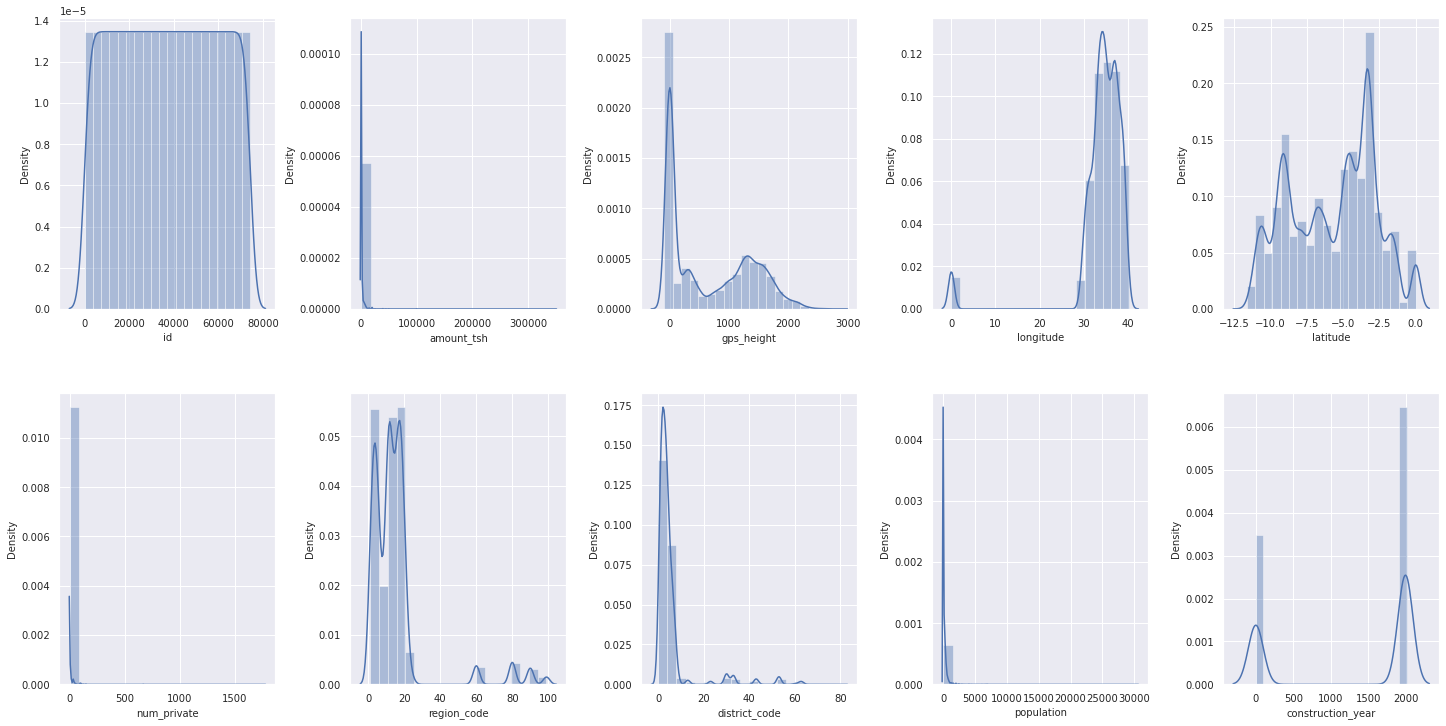

In [26]:
#Variables numéricas
fig, axs = plt.subplots(ncols=5, nrows=2, figsize=(20, 10))
axs = axs.flatten() # 

index = 0
for k,v in df[num_cols].items(): 
    if  (k == 'permanencia'):
        sns.countplot(v, ax=axs[index])
    else:
        sns.distplot(v, bins=20, ax=axs[index])
    index += 1

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

Inicialmente, note que hay un buen porcentaje de variables nominales o categóricas. Vamos a orientar nuestro estudio a datos missings y veremos que provecho podemos sacarle a cada una de las varaibles. Observamos aquellas variables que son extrañas por su descripción, número de missings o número de uniques, así mismo variables que no consideramos que tiene una gran variabilidad. 

In [27]:
initial_drop = [
    'id', # Identificador 
    'wpt_name', # NO es considerada como una variable con alta representatividad
    'num_private', # Representa una variable desconocida 
    'recorded_by', # No representa una gran variabilidad en los datos 
    'scheme_name' #Cantidad considerable de missings 
]

df.drop(columns=initial_drop,axis=1,inplace=True)

Estudiando la variable *date_recorded*, encontramos que la mejor forma de caracterizar los datos respecto a la variable *construction_year*, es agrupandola por año. 

Así mismo, *construction_year* se rellenó con la media y se dejó la variable *age* para obtener el tiempo en años de los pozos. 

In [28]:
#date_recorded and construction_year 

df['year_recorded'] = pd.DatetimeIndex(df['date_recorded']).year
sort= df['year_recorded'].value_counts().sort_values()
df.drop(columns=['date_recorded'], inplace=True)

df['construction_year'].replace(0, round(df.loc[df['construction_year'] > 0, 'construction_year'].mean()), inplace=True)

df['age'] = df['year_recorded'] - df['construction_year']

df.drop(columns=['year_recorded','construction_year'], inplace=True)

Evaluaremos la correlación entre variables de la siguiente manera. 

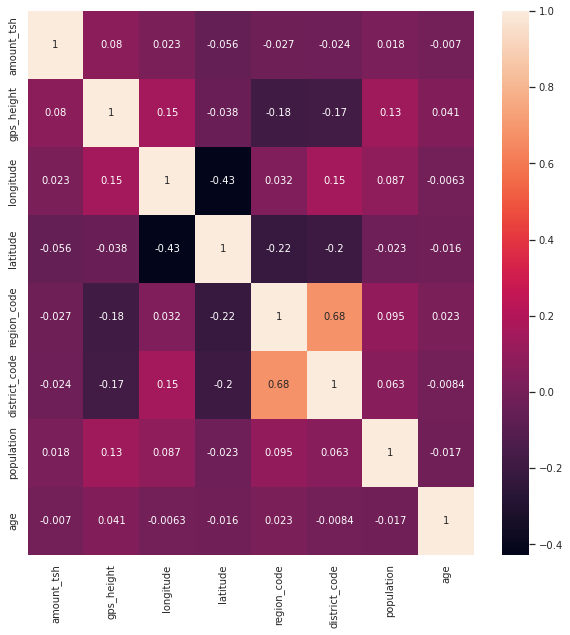

In [29]:
#continuas
corr_matrix = df.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

corr_df = df.corr(method='pearson')
plt.figure(figsize=(10, 10))
sns.heatmap(corr_df, annot=True)
plt.show()

In [30]:
# categoricas #tablas de contingencia VCrammer
ct1=pd.crosstab(index=df['water_quality'], columns=df['quality_group'], margins=True)
ct2=pd.crosstab(index=df['extraction_type'], columns=df['extraction_type_class'], margins=True)
ct3=pd.crosstab(index=df['extraction_type_class'], columns=df['extraction_type_group'], margins=True)
ct4=pd.crosstab(index=df['scheme_management'], columns=df['management'], margins=True)
ct5=pd.crosstab(index=df['payment'], columns=df['payment_type'], margins=True)
ct6=pd.crosstab(index=df['quantity'], columns=df['quantity_group'], margins=True)
ct7=pd.crosstab(index=df['source'], columns=df['source_type'], margins=True)
ct8=pd.crosstab(index=df['waterpoint_type'], columns=df['waterpoint_type_group'], margins=True)
ct9=pd.crosstab(index=df['management_group'], columns=df['management'], margins=True)


Ya que no realizaremos un fuerte Análisis de Componentes principales, podriamos descartar las siguientes variables. 

In [31]:
drop_columns = [ 
    'water_quality',
    'management',
    'installer',
    'extraction_type_group',
    'quantity_group',
    'source_type',
    'waterpoint_type_group',
    'payment_type',
    'management_group',
    'extraction_type',
    'district_code'
]

df.drop(columns=drop_columns, inplace=True)

Pasaremos a realizar el estudios de variables categoricas, cuyos valores podemos imputar por medio de la moda.

In [32]:

df['funder'].fillna(value='Unknown',inplace=True)
df['funder'].replace(to_replace = '0', value ='Unknown' , inplace=True)

df['scheme_management'].fillna(value='Unknown',inplace=True)
df['scheme_management'].replace(to_replace = '0', value ='Unknown' , inplace=True)



#Rellenamos con la moda 
df.permit.fillna(df.permit.mode().values[0], inplace=True)
df.public_meeting.fillna(df.public_meeting.mode().values[0], inplace=True)

df.subvillage.fillna(df.subvillage.mode().values[0],inplace=True)

# Convertimos a numéricos
df.loc[:, ['permit', 'public_meeting']] = df.loc[:, ['permit', 'public_meeting']].astype('int')

Haremos un estudio de regresión lineal múltiple respecto a las variables, *latitude* y *longitude* para imputar *gps_height*. 

In [33]:
# Asignamos a longitude = 0 y latitude > -0.3 el valor np.nan | Asignamos np.nan a gps_height = 0
df.loc[df.latitude > -0.3, 'latitude'] = np.nan
df.loc[df.longitude == 0, 'longitude'] = np.nan
df.loc[df.gps_height == 0, 'gps_height'] = np.nan

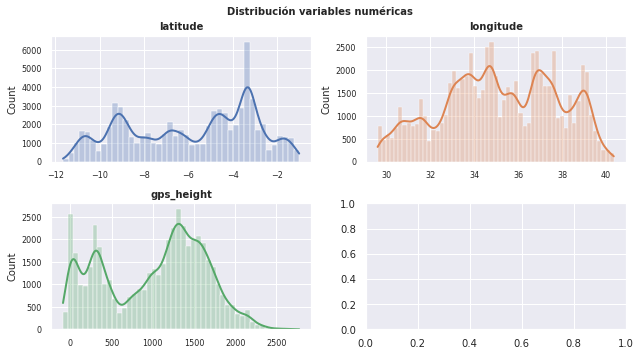

In [34]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 5))
axes = axes.flat
columnas_numeric = df[['latitude','longitude','gps_height']]

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = df,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")


    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

Tiene sentido ajustar un modelo lineal múltiple con el objetivo de predecir la variable *gps_hight* en función de la longitud y la latitud e imputar sobre la predicción.

In [35]:
# Imputamos los valores geográficos en base a los valores geográficos
df_encoded = df[['region','region_code','lga','ward']].copy()
for col in df_encoded:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])
df_encoded[['latitude','longitude']] = df[['latitude','longitude']]

# Latitude
reg = LinearRegression(n_jobs=-1).fit(df_encoded.loc[df_encoded.latitude.notna()].drop(columns=['latitude','longitude']),
                                          df_encoded.loc[df_encoded.latitude.notna(), 'latitude'])

x = reg.predict(df_encoded.loc[df_encoded.latitude.isna()].drop(columns=['latitude','longitude']))
df.loc[df.latitude.isna(), 'latitude'] = x

# Longitude
reg = LinearRegression(n_jobs=-1).fit(df_encoded.loc[df_encoded.longitude.notna()].drop(columns=['latitude','longitude']),
                                          df_encoded.loc[df_encoded.longitude.notna(), 'longitude'])

x = reg.predict(df_encoded.loc[df_encoded.longitude.isna()].drop(columns=['latitude','longitude']))
df.loc[df.longitude.isna(), 'longitude'] = x

# Mismo proceso para gps_height
df_encoded[['latitude','longitude','gps_height']] = df[['latitude','longitude','gps_height']]

reg = LinearRegression(n_jobs=-1).fit(df_encoded.loc[df_encoded.gps_height.notna()].drop(columns=['gps_height']),
                                          df_encoded.loc[df_encoded.gps_height.notna(), 'gps_height'])

x = reg.predict(df_encoded.loc[df_encoded.gps_height.isna()].drop(columns=['gps_height']))

df.loc[df.gps_height.isna(), 'gps_height'] = x

In [36]:
df['gps_height'].describe()

count    74250.000000
mean      1098.056412
std        538.600868
min        -90.000000
25%        798.000000
50%       1201.295354
75%       1442.000000
max       2777.000000
Name: gps_height, dtype: float64

Pasamos a estudiar la transformación a variables dummies, por medio de *LabelEncoder()* este codificador puede entrenarse con el método fit.  En este entrenamiento se identifican los valores únicos de la característica y los valores numéricos por los que se van a reemplazar y el método fit_transform nos permite entrenar el codificador y transformar el conjunto de datos simultáneamente. 

In [37]:
df_encoded = df.copy()
for col in df.select_dtypes(include='O').drop(columns=[]):
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])
    
# Dummy Encoding #
df_encoded = pd.get_dummies(df_encoded,drop_first=True)

Pasamos a hacer el tratamiento de outliers, utilizando z-score.

amount_tsh


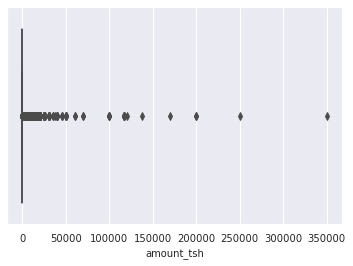

gps_height


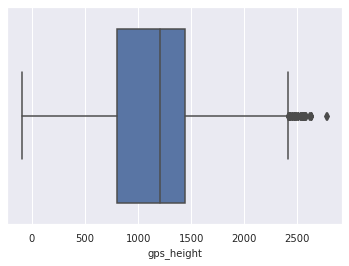

longitude


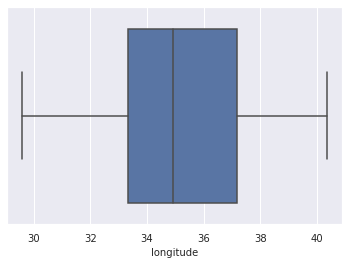

latitude


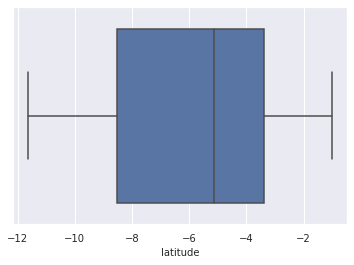

region_code


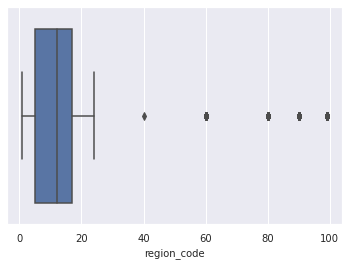

population


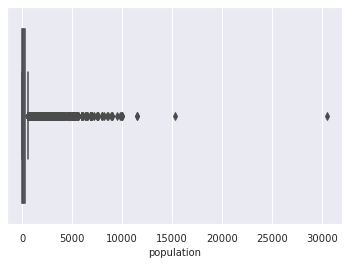

public_meeting


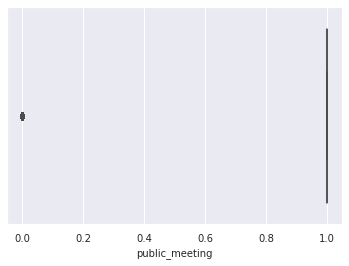

permit


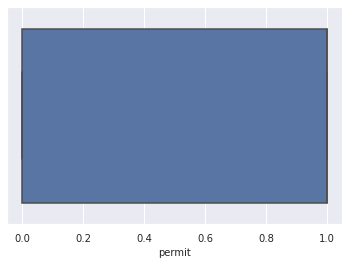

age


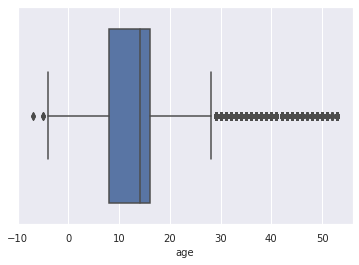

In [38]:

corr_matrix_2 = df.select_dtypes(include=['float64', 'int'])
for i in corr_matrix_2:
    sns.boxplot(x=df[i])
    print(i)
    plt.show()
    

In [39]:
threshold = 3
z = np.abs(stats.zscore(df['population']))
print(z)

0        0.152310
1        0.210683
2        0.147000
3        0.260572
4        0.383692
           ...   
74245    0.341237
74246    5.899702
74247    0.040862
74248    0.065277
74249    0.298781
Name: population, Length: 74250, dtype: float64


In [40]:
threshold = 3
z = np.abs(stats.zscore(df['region_code']))
print(z)

0        0.243616
1        0.270412
2        0.327526
3        4.268404
4        0.156184
           ...   
74245    0.529186
74246    0.643415
74247    0.129387
74248    0.300730
74249    0.300730
Name: region_code, Length: 74250, dtype: float64


In [41]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74250 entries, 0 to 74249
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             74250 non-null  float64
 1   funder                 74250 non-null  int64  
 2   gps_height             74250 non-null  float64
 3   longitude              74250 non-null  float64
 4   latitude               74250 non-null  float64
 5   basin                  74250 non-null  int64  
 6   subvillage             74250 non-null  int64  
 7   region                 74250 non-null  int64  
 8   region_code            74250 non-null  int64  
 9   lga                    74250 non-null  int64  
 10  ward                   74250 non-null  int64  
 11  population             74250 non-null  int64  
 12  public_meeting         74250 non-null  int64  
 13  scheme_management      74250 non-null  int64  
 14  permit                 74250 non-null  int64  
 15  ex

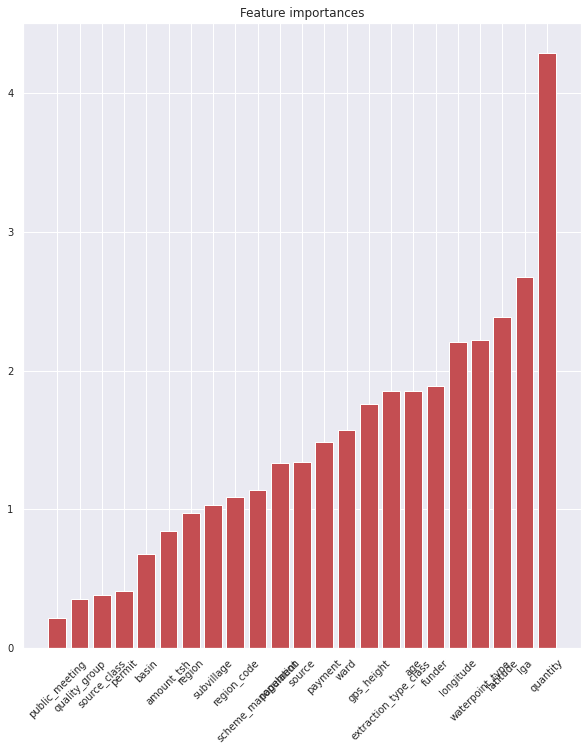

In [42]:
importances = features_importance(df_encoded[:len(labels_tmp)], labels_tmp )

Notemos que la variable que más aporta al modelo es quantity, sin embargo estudiaremos que sucede con la validación. 

# Muestreo los datos, construyendo un dataset de train y test

   - Muestreo estratificado en función de la variable respuesta para que en los splits sus categorías estén bien representadas.
       - Split 80/20.
       - Entrenamiento (80%/train)
       - Validación (20%/train )
       - Testing (El conjunto de datos a predecir)
       

In [64]:
train = df_encoded[:len(labels_tmp)]
test = df_encoded[len(labels_tmp):]

X_train, X_val, y_train, y_val = train_test_split(train, labels_tmp, test_size=0.2, random_state=42)

In [77]:
# Modelo y predicciones:
tree_mod = DecisionTreeClassifier(criterion="gini").fit(X_train, y_train)
tree_pred = tree_mod.predict(X_val)

# Métricas:
metrics(y_val, tree_pred)

matriz de confusión
[[5100  435  922]
 [ 389  307  155]
 [ 890  180 3502]]
accuracy
0.7499158249158249


In [67]:
#RandomForest
classifier2 = RandomForestClassifier().fit(X_train, y_train)
pred2 = classifier2.predict(X_val)

# Métricas:
metrics(y_val, pred2)


matriz de confusión
[[5732  171  554]
 [ 432  302  117]
 [ 914   86 3572]]
accuracy
0.8085858585858586


# Testing 

Con los anteriores resultados, realizamos las predicciones del conjunto test. 

In [80]:
preds_test = classifier2.predict(test)

In [94]:
convert = map(lambda x: 'functional' if x == 0 else ('functional needs repair' if x == 1 else 'non functional'), preds_test)
result = pd.DataFrame({'status_group':convert})
result

,status_group
0,non functional
1,functional
2,functional
3,non functional
4,functional
...,...
14845,non functional
14846,functional
14847,functional
14848,functional


In [95]:
result.to_csv('pump_it_up_prediction.csv', index=False)